In [7]:
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
from jax import random 
import iqpopt as iqp
import iqpopt.gen_qml as genq
from iqpopt.gen_qml.utils import median_heuristic
import jax
import jax.numpy as jnp

In [1]:
from datasets.latent_mnist import LatentDataset

# Example of loading a saved dataset
latent_file = './datasets/mnist_latent_train.npy'
label_file = './datasets/mnist_labels_train.npy'
dataset = LatentDataset(latent_file, label_file, batch_size=1)

ds = dataset.load()

Crear instancia del AutocoderTrainer para poder usar la reconstruction function

In [8]:
from src.utils.autoencoder_trainer import AutoencoderTrainer

rng = random.PRNGKey(0)
binary_vae = model(latents=20)
input_shape = (64, 196)
learning_rate = 3e-4
# Create an instance of the trainer with your binary VAE model
trainer = AutoencoderTrainer(binary_vae, learning_rate, rng, input_shape)
state = trainer.state
params = trainer.params

In [2]:
from src.autoencoders.simple_vae import model,Decoder
from src.utils.autoencoder_trainer import AutoencoderTrainer
from src.utils.autoencoder_manager import get_latent_dataset, restore_model_state, reconstruct

binary_vae = model(latents=20)
decoder = Decoder()

In [26]:
ckpt_dir = "weights/binary_vae_500epoch_3e-4lr/checkpoint_461"
state = restore_model_state(ckpt_dir, state)

print("Weights loaded successfully.")

Checkpoint restored from directory 'c:\Users\marcos.arroyo\Documents\GitHub\Latent-IQP\weights\binary_vae_500epoch_3e-4lr\checkpoint_461'.
Weights loaded successfully.


In [ ]:
dataset = ds.take(10)
train = []
lab = []
for latent, label in dataset:
    train.append(latent)
    lab.append(label)

[<tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([2])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([2])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([8])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([9])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([4])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([2])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([9])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([4])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([4])>]


reconstructing only based on  tf.Tensor([[0 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0]], shape=(1, 20), dtype=int64)
tf.Tensor([2], shape=(1,), dtype=int64)
(1, 196)
(14, 14)


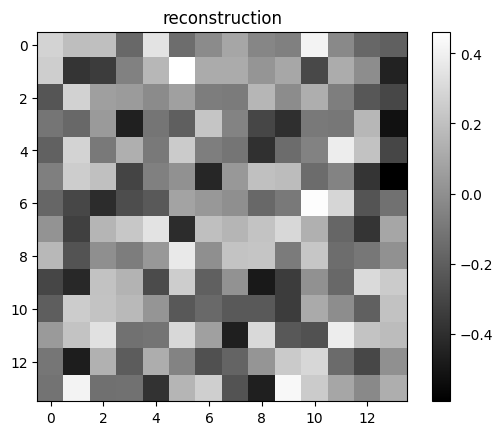

In [25]:
rec = reconstruct(binary_vae, params, train[2])
print(lab[2])
print(rec.shape)
rec = rec.reshape(14,14)
print(rec.shape)
# Plotting the matrix
plt.imshow(rec, cmap='gray', interpolation='nearest')
plt.colorbar()  # Add color bar to the side
plt.title('reconstruction')
plt.show()